<a href="https://colab.research.google.com/github/sgr1118/EX/blob/main/%5BExp_15%5D_Deep_learning_to_read_characters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 15-9. 프로젝트 : 다양한 OCR모델 비교하기

In [ ]:
# 라이브러리 업데이트
!pip install google-api-python-client google-cloud-vision
!pip install keras_ocr matplotlib==3.3.0
!apt install tesseract-ocr
!apt install libtesseract-dev
!pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 386 kB 4.3 MB/s 
     |████████████████████████████████| 47 kB 5.4 MB/s 
     |████████████████████████████████| 1.0 MB 68.1 MB/s 
     |████████████████████████████████| 115 kB 91.5 MB/s 
     |████████████████████████████████| 4.6 MB 70.0 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.47.0
    Uninstalling grpcio-1.47.0:
      Successfully uninstalled grpcio-1.47.0
  Attempting uninstall: google-api-core
    Found existing installation: google-api-core 1.31.6
    Uninstalling google-api-core-1.31.6:
      Successfully uninstalled google-api-core-1.31.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 941 kB/s 
     |████████████████████████████████| 11.5 MB 5.7 MB/s 
     |████████████████████████████████| 9.5 MB 29.5 MB/s 
     |████████████████████████████████| 957 kB 58.2 MB/s 
     |████████████████████████████████| 604 kB 89.2 MB/s 
     |████████████████████████████████| 50 kB 8.2 MB/s 
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19582 sha256=2c9fd51ec48b4e1bbc4ea9b907f39f9358b1b7f9f2fc05f68ea384287c9b344f
  Stored in directory: /root/.cache/pip/wheels/5f/55/ab/36a76989f7f88d9ca7b1f68da6d94252bb6a8d6ad4f18e04e9
Successfully built validators
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
tesseract-ocr set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libleptonica-dev
The following NEW packages will be installed:
  libleptonica-dev libtesseract-dev
0 upgraded, 2 newly installed, 0 to remove and 20 not upgraded.
Need to get 2,755 kB of archives.
After this operation, 13.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bi

In [ ]:
!sudo apt install tesseract-ocr-kor

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr-kor is already the newest version (4.00~git24-0e00fe6-1.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


# Step1. 검증용 데이터셋 준비

OCR 관련해서 오늘 다루어본 주제는 텍스트의 모양과 크기, 배치, 노이즈 등 OCR의 성능에 영향을 미치는 요인들에 관한 것이었습니다. 여러분들은 위 3가지 기능들이 이미지에 나타난 특징에 따라 얼마나 정확하게 문자를 detect하고 recognize하는지를 검증하기 위한 이미지 데이터를 모아야 합니다. 이미지가 많을수록 좋겠지만 검증해야 할 항목별로 고루 갖춰지는 것도 중요합니다.

가능하다면 함께 학습하는 동료들과 힘을 합쳐보는 것을 추천합니다. 그렇다고 너무 많은 이미지 데이터로 검증하는 것은 이후 결과를 정리하는 것이 힘들 수 있으니 테스트용 이미지는 아무리 많아도 20장을 넘기지 않는 것으로 합시다.


In [ ]:
# 라이브러리 불러오기

import os
import matplotlib.pyplot as plt
import cv2

import keras_ocr

import pytesseract
from PIL import Image
from pytesseract import Output

In [ ]:
# 데이터 불러오기 

data_path = '/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample'

file_list = os.listdir(data_path)
file_path = [data_path+'/'+name for name in file_list]
file_path = sorted(file_path)
file_path

['/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample/sample1.jpg',
 '/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample/sample2.jpg',
 '/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample/sample3.jpg',
 '/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample/sample4.jpg',
 '/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample/sample5.jpg']

# Step2. keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택 사항)

위 두 가지 모듈을 활용하는 방법에 대해서는 코드 레벨로 이미 경험해 보셨을 것입니다. 이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아 봅시다. 가능하다면 Google OCR API를 포함해 세 가지 모듈을 다 써보세요

1. keras-ocr 사용

[keras-ocr 공식문서](https://keras-ocr.readthedocs.io/en/latest/index.html)


In [ ]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


In [ ]:
# 테스트에 사용할 이미지
images = [keras_ocr.tools.read(path) for path in file_path]
prediction_groups = [pipeline.recognize([path]) for path in file_path]

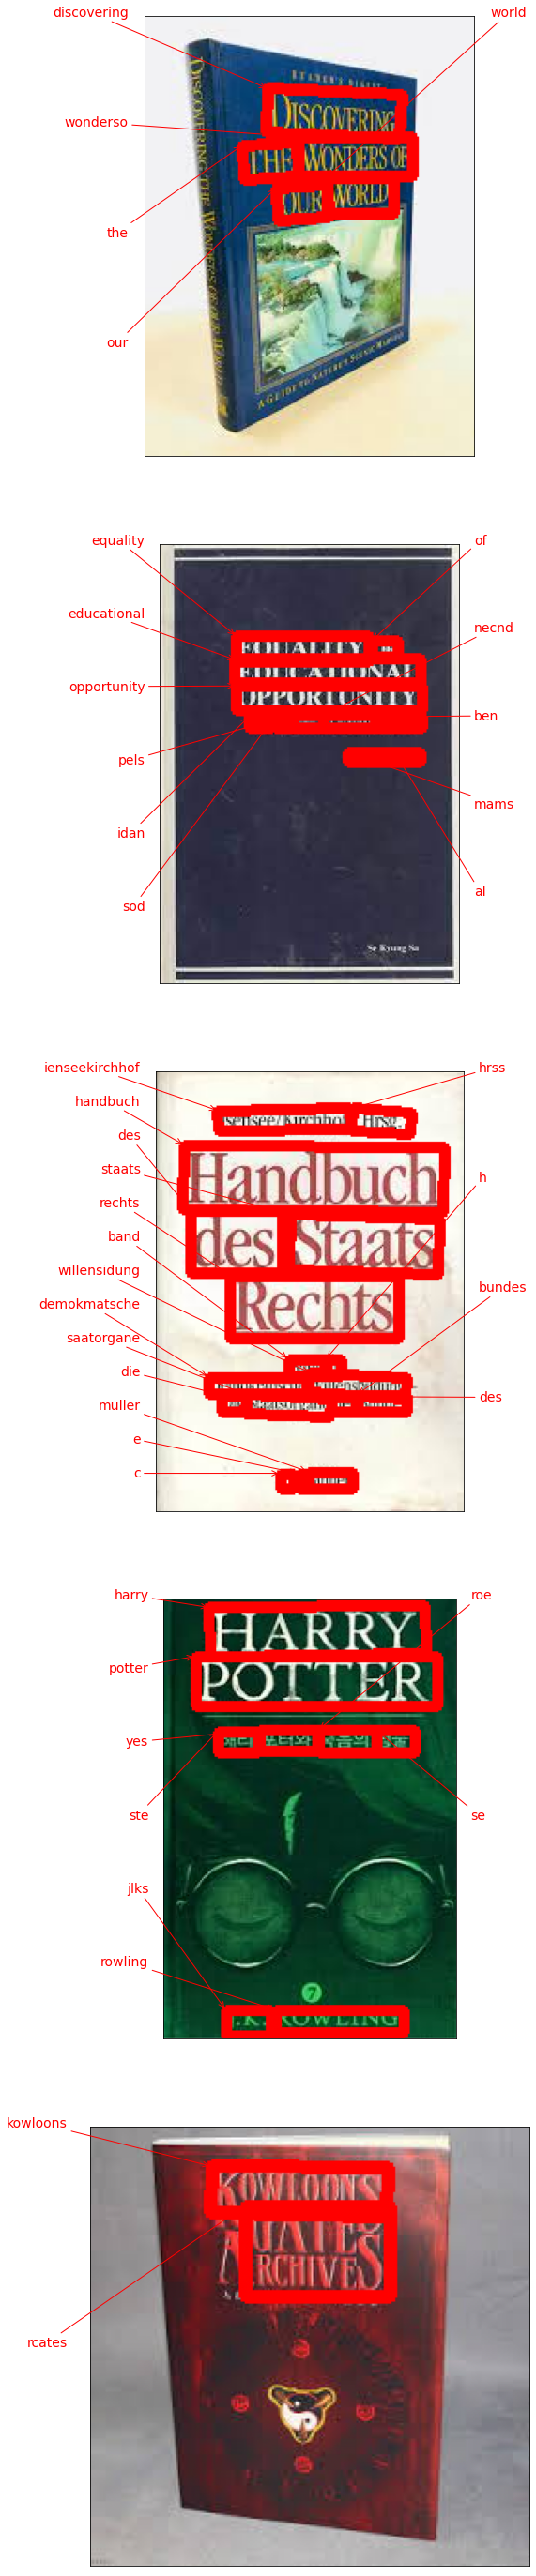

In [ ]:
# 인식결과 시각화

fig, axs = plt.subplots(nrows=len(images), figsize=(50, 50))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

2. Tesseract

[Pytesseract](https://pypi.org/project/pytesseract/)

이번에도 도서 이미지를 사용하지만 집에있는 한국도서의 표지를 사용할 예정이다.

사용한 교재 목록

(1) [부자 되는 법을 가르쳐 드립니다](http://www.kyobobook.co.kr/product/detailViewKor.laf?mallGb=KOR&ejkGb=KOR&barcode=9791135455063)

(2) [김기현의 자연어처리 딥러닝 캠프](http://www.kyobobook.co.kr/product/detailViewKor.laf?ejkGb=KOR&mallGb=KOR&barcode=9791162241974)

In [ ]:
# 테서랙트로 문자 검출하고 이미지 자르기 (detection)

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(
    image_path = '/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample2/sample4.jpg', 
    output_path = '/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample2_output'):
  if not os.path.exists(output_path):
    os.mkdir(output_path)
  custom_oem_psm_config = r'--oem 3 --psm 3'
  image = Image.open(image_path)

  # 한국어라면 lang='kor'
  recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config, 
        output_type = Output.DICT)
  
  top_level = max(recognized_data['level'])
  index = 0
  cropped_image_path_list = []
  for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
  return cropped_image_path_list

In [ ]:
work_dir = '/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample2_output'
img_file_path = '/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample2/sample4.jpg'    #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample2_output/0000.png
/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample2_output/0001.png
/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample2_output/0002.png
/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample2_output/0003.png
/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample2_output/0004.png
/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample2_output/0005.png
/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample2_output/0006.png
/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample2_output/0007.png
/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample2_output/0008.png
/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample2_output/0009.png
/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample2_output/0010.png
/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample2_output/0011.png
/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample2_output/0012.png
/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample2_output/0013.png
/content/drive/MyDrive/Aiffel/EX/Ex15_image/samp

In [ ]:
# 인식 이미지 text 출력
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)


때

…'배

Ｌ

_…

으으 알

「

2

아이어

0

18

2

40104

~

49

@

410!


|겨40

10900

아마존

베스트셀러

Done


In [ ]:
# 인식 이미지 text 출력
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)


「 ㆍ *…ㅜ~ |

-을 월 오,

1

0!

뜨웃

!

는' |

()+@

대


기


이


저로

기




와

)}ㅅ

|

김기현

지음

는

이

던|

|

ㄷㄷ

|

=

41071[||

1 16010,

106,


Done


2. Tesseract

외국 도서 표지 사용해보기

In [ ]:
# 테서랙트로 문자 검출하고 이미지 자르기 (detection)

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(
    image_path = '/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample/sample3.jpg', 
    output_path = '/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample_output'):
  if not os.path.exists(output_path):
    os.mkdir(output_path)
  custom_oem_psm_config = r'--oem 3 --psm 3'
  image = Image.open(image_path)

  # 한국어라면 lang='kor'
  recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config, 
        output_type = Output.DICT)
  
  top_level = max(recognized_data['level'])
  index = 0
  cropped_image_path_list = []
  for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
  return cropped_image_path_list

In [ ]:
work_dir = '/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample_output'
img_file_path = '/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample/sample3.jpg'    #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample_output/0000.png
/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample_output/0001.png
/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample_output/0002.png
/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample_output/0003.png
/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample_output/0004.png
/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample_output/0005.png
/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample_output/0006.png
/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample_output/0007.png
/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample_output/0008.png
/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample_output/0009.png
/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample_output/0010.png
/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample_output/0011.png


In [ ]:
# 인식 이미지 text 출력
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

# 한글보다 영어의 출력이 보다 정확하긴하다.

lsensee/ Kirchholt

( Hrsg.)

Handbuch


des Staats

Rechts

Jemokratiane


; =

be

P Maatsorgane

CF Mater

Done


# Step3. 테스트 결과 정리

모듈들마다 출력 형태가 다릅니다. 분석을 위해 결과를 일목요연하게 정리해 보는 것이 도움이 될 것입니다. 시각화 방법이 함께 활용된다면 더욱 좋겠군요.

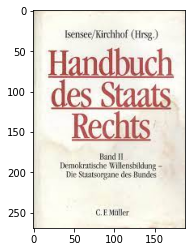

In [ ]:
# 테스트용 이미지 불러오기
import cv2

test_image_path = '/content/drive/MyDrive/Aiffel/EX/Ex15_image/sample/sample3.jpg'
img_bgr = cv2.imread(test_image_path)    # OpenCV로 이미지를 읽기
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # opencv는 BGR를 사용하기에 RGB 이미지로 바꾸기
plt.imshow(img_rgb)
plt.show()

- keras-ocr과 테서렉트로 출력해보았을 때 양호하게 출력이 되는 이미지라고 생각하여 지정하였다.

- 가장 큰 제목을 얼마나 잘 인식하는지 비교하기로 하였다.

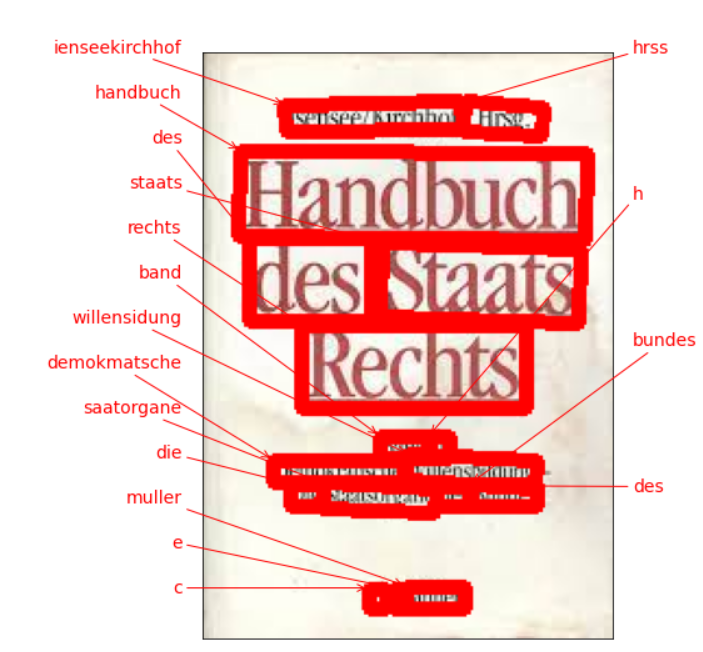

- 큰 제목을 기준으로 완벽하게 인식하였다.

- 로마자로 적힌 숫자는 인식하지 못하는 것처럼 보였다.

- 대부분 유사하게 잘 인식하였다.

2. 테서렉트 인식 결과

In [ ]:
recognize_images(cropped_image_path_list)

lsensee/ Kirchholt

( Hrsg.)

Handbuch


des Staats

Rechts

Jemokratiane


; =

be

P Maatsorgane

CF Mater

Done


- 테서렉트 또한 큰 제목을 기준으로 대문자 소문자를 구분하며 잘 인식하였다.

- 다만 큰 제목 밑에있는 부제목 문구는 거의 인식을 할 수 없는 결과를 보였다.

- 문자가 아닌 (), ; = 기호를 keras-ocr과 달리 출력을하지만 정확하지 않은 내용으로 출력하곤한다.

# Step4. 결과 분석과 결론 제시

우선 여러분들이 구현하고자 하는 서비스의 목적과 내용을 먼저 정리합니다. 여러분들이 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가 기준을 제시합니다. 그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정합니다.

1. 평가 기준
- 표지에서 얼만큼 텍스트를 구체적으로 추출하였는가?

2. 결론
- 만약에 제가 가장 우선으로 사용한다면 keras-ocr를 사용하겠습니다. 이유는 문자 인식 수준이 테서렉트보다 더 좋았기 때문입니다. 큰 제목은 두 ocr 모델은 큰 차이가 발생하지 않았지만 부제목에서 인식 성능이 많은 차이가 발생했습니다.




# 회고

1. 테서렉트 성능 개선이 어려웠습니다. 향후 방법을 다시 찾아보아야 할 거같습니다.